In [167]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2

from tensorflow import keras
from math import ceil
from numba import njit, prange
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array
from pyts.preprocessing import MinMaxScaler
from pyts.approximation import PiecewiseAggregateApproximation
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils

In [168]:
Welding_data = np.load('E:/Result/ver.3.22/MTF/MTF.npz')

X_data = Welding_data['X_data']
y_data = Welding_data['y_data']
i_data = Welding_data['i_data']

Welding_data.close()

In [169]:
from sklearn.model_selection import train_test_split

rs = 7

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X_data, y_data, i_data, test_size= 0.2, shuffle= True, random_state= rs)

X_train = X_train.reshape(-1, 300, 300, 2) / 255.0

In [170]:
X_train, X_val, y_train, y_val, i_train, i_val = train_test_split(X_train, y_train, i_train, test_size= 0.2, shuffle= True, random_state= rs)

In [202]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(16, kernel_size= 4, activation= 'relu', padding= 'same', input_shape=(300, 300, 2)))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(32, kernel_size= 4, activation= 'relu', padding= 'same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(64, kernel_size= 4, activation= 'relu', padding= 'same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(128, kernel_size= 4, activation = 'relu', padding= 'same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(256, kernel_size= 4, activation = 'relu', padding= 'same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(512, kernel_size= 4, activation = 'relu', padding= 'same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(3, activation= 'softmax'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 300, 300, 16)      528       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 150, 150, 32)      8224      
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 75, 75, 64)        32832     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 37, 37, 64)     

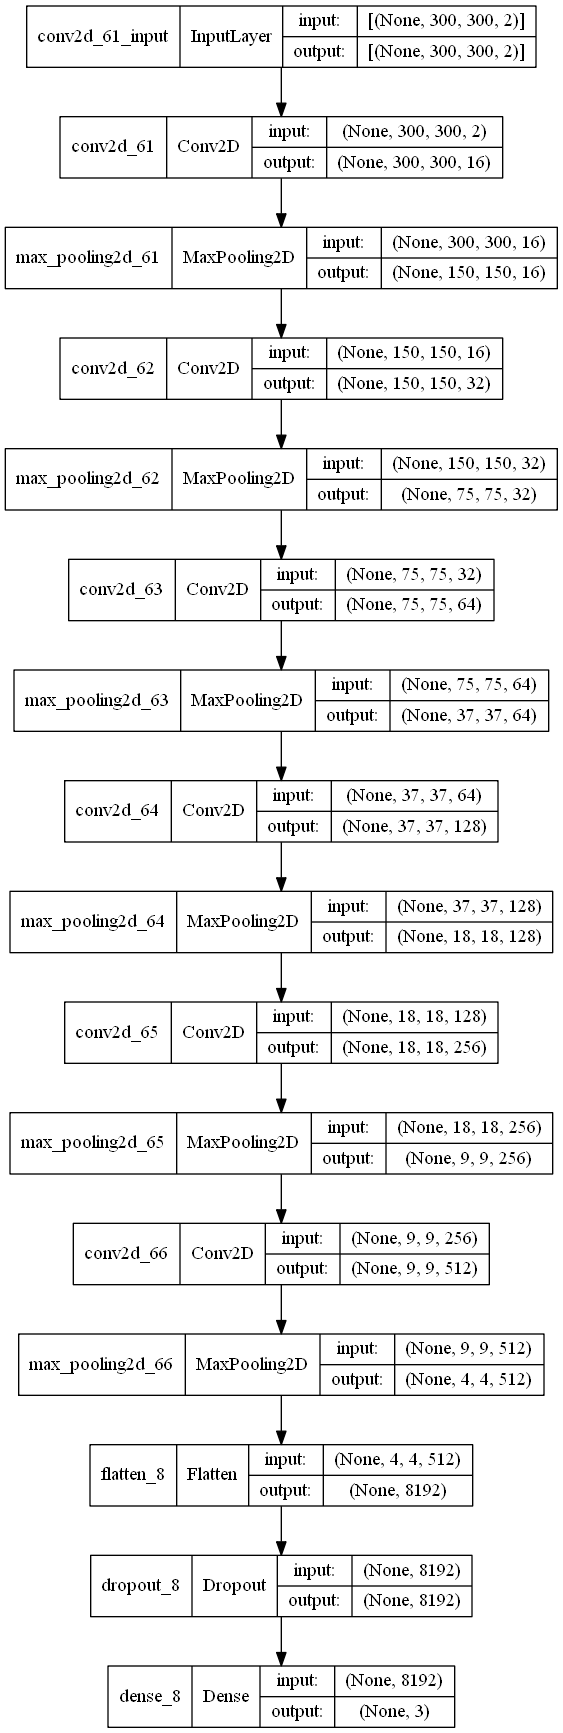

In [203]:
keras.utils.plot_model(model, show_shapes= True, to_file= 'self_CNN.png')

In [205]:
model.compile(
    optimizer= 'adam',
    loss= 'sparse_categorical_crossentropy',
    metrics= 'accuracy'
)

check_point_cb = keras.callbacks.ModelCheckpoint(
    'self_CNN.h5',
    save_best_only = True
)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience= 4,
    restore_best_weights= True
)

In [206]:
with tf.device('/gpu:0'):
    history = model.fit(
        X_train, y_train,
        epochs= 100,
        verbose= 1,
        batch_size= 13,
        validation_data= (X_val, y_val),
        callbacks= [check_point_cb,early_stopping_cb]
    )

Epoch 1/100
58/58 [==============================] - 4s 49ms/step - loss: 1.1060 - accuracy: 0.3316 - val_loss: 1.0990 - val_accuracy: 0.2698
Epoch 2/100
58/58 [==============================] - 2s 42ms/step - loss: 1.0990 - accuracy: 0.3183 - val_loss: 1.1005 - val_accuracy: 0.3386
Epoch 3/100
58/58 [==============================] - 2s 42ms/step - loss: 1.0985 - accuracy: 0.3475 - val_loss: 1.1026 - val_accuracy: 0.3386
Epoch 4/100
58/58 [==============================] - 2s 42ms/step - loss: 1.0985 - accuracy: 0.3462 - val_loss: 1.1013 - val_accuracy: 0.3386
Epoch 5/100
58/58 [==============================] - 2s 42ms/step - loss: 1.0984 - accuracy: 0.3369 - val_loss: 1.1008 - val_accuracy: 0.3386


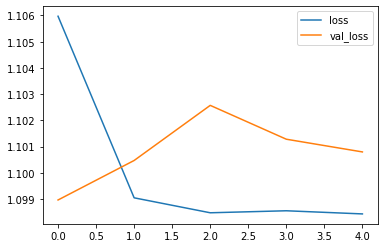

In [207]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [208]:
model.evaluate(X_val, y_val)

6/6 [==============================] - 1s 101ms/step - loss: 1.0990 - accuracy: 0.2698


[1.098958969116211, 0.2698412835597992]

In [218]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 300, 300, 2), dtype=tf.float32, name='conv2d_61_input'), name='conv2d_61_input', description="created by layer 'conv2d_61_input'")


In [226]:
model.layers

In [242]:
conv_acti = keras.Model(model.input, model.layers[0].output)

In [243]:
inputs = X_train[0:1] / 255.0
feature_maps= conv_acti.predict(inputs)

In [244]:
print(feature_maps.shape)

(1, 300, 300, 16)


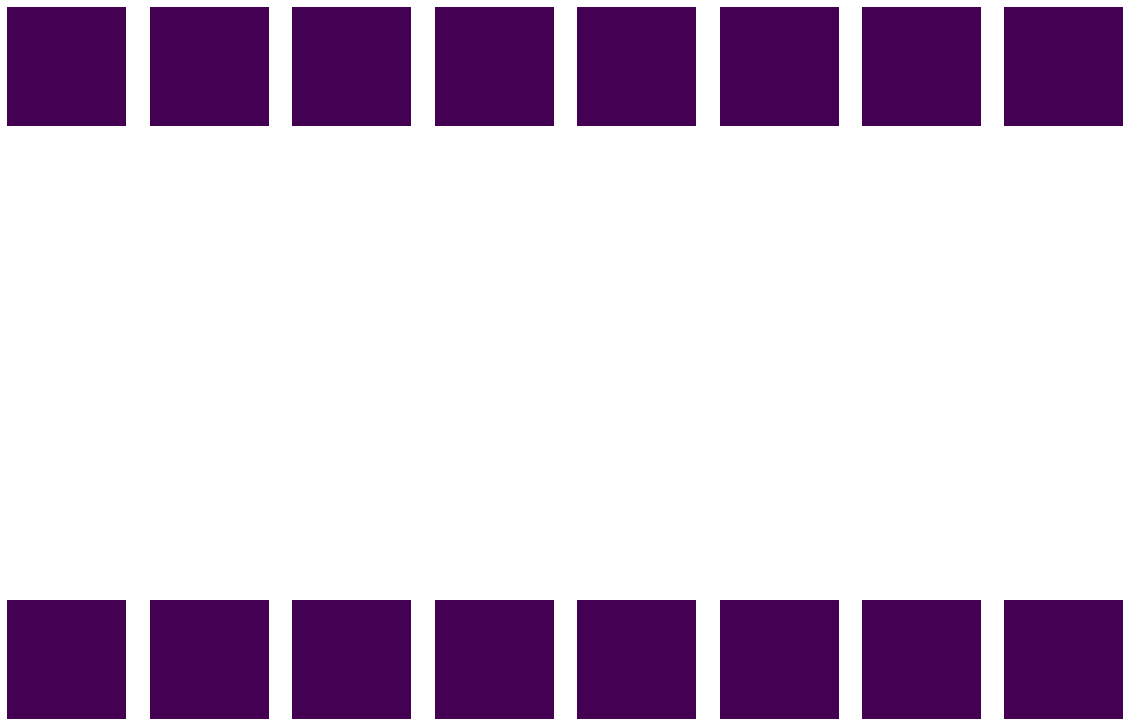

In [246]:
fig, axs = plt.subplots(2, 8, figsize= (20, 20))
for i in range(2):
    for j in range(8):
        axs[i,j].imshow(feature_maps[0,:,:, i*8+j])
        axs[i,j].axis('off')
plt.show()